In [1]:
import sympy as sym

import numpy as np

import itertools
import matplotlib.pyplot as plt

sym.init_printing()

In [2]:
import evol_dynamics

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
s_one = (0, 0, 0)
s_two = (1, 1, 0)

In [5]:
payoff_vector = np.array(evol_dynamics.donation_game(1, 3))

In [6]:
evol_dynamics.steady_state(s_two, s_one, delta=0.999) @ payoff_vector 

**Defining variables**

In [7]:
y_1, p_1, q_1 = sym.symbols("y_1, p_1, q_1")
y_2, p_2, q_2 = sym.symbols("y_2, p_2, q_2")

In [8]:
s_one = (y_1, p_1, q_1)
s_two = (y_2, p_2, q_2)

In [9]:
s_one

In [10]:
combinations = itertools.product([s_one, s_two], repeat=2)

In [11]:
list(combinations)

**Get expression using code**

In [11]:
d = sym.symbols("delta")

In [12]:
v_zero = evol_dynamics.expected_distribution_opening_round(s_one, s_two)

In [13]:
v_zero

In [14]:
M = evol_dynamics.markov_chain_for_reactive_strategies(s_one, s_two)

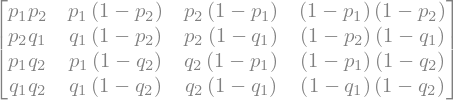

In [15]:
sym.Matrix(M)

In [16]:
inverse = sym.Matrix(np.identity(4) - d * M).inverse_ADJ()

In [17]:
expression = (1 - d) * sym.Matrix(v_zero).reshape(1, 4) @ inverse

**Check the written mathematics**

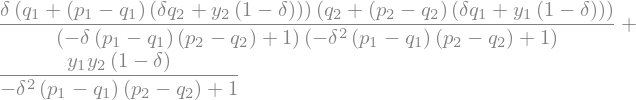

In [18]:
u_R = evol_dynamics.formulation.probability_being_in_state_R(s_one, s_two, d)
u_R

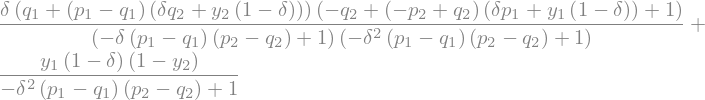

In [19]:
u_S = evol_dynamics.formulation.probability_being_in_state_S(s_one, s_two, d)
u_S

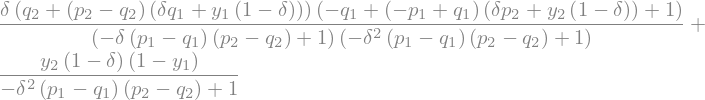

In [20]:
u_T = evol_dynamics.formulation.probability_being_in_state_T(s_one, s_two, d)
u_T

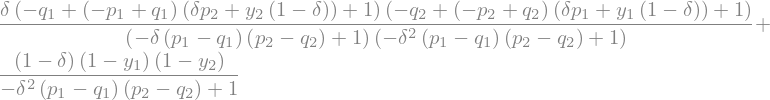

In [21]:
u_P = evol_dynamics.formulation.probability_being_in_state_P(s_one, s_two, d)
u_P

In [22]:
(u_R - expression[0]).simplify(), (u_S - expression[1]).factor()

In [23]:
(u_T - expression[2]).factor(), (u_P - expression[3]).factor()

### Check  analysis of ALLD into GTFT

In [24]:
q = sym.symbols("q")

N, k = sym.symbols("N, k")

In [25]:
ALLD = (0, 0, 0)
GTFT = (1, 1, q)

**Last round**

**States of Eq. (9) and (10)**

In [26]:
evol_dynamics.formulation.probability_being_in_state_R(GTFT, GTFT, d).factor()

In [27]:
evol_dynamics.formulation.probability_being_in_state_R(GTFT, ALLD, d).factor()

In [28]:
evol_dynamics.formulation.probability_being_in_state_R(GTFT, ALLD, d).factor()

In [29]:
evol_dynamics.formulation.probability_being_in_state_T(ALLD, GTFT, d).factor()

In [30]:
(
    evol_dynamics.formulation.probability_being_in_state_S(GTFT, GTFT, d).factor(),
    evol_dynamics.formulation.probability_being_in_state_T(GTFT, GTFT, d).factor(),
    evol_dynamics.formulation.probability_being_in_state_P(GTFT, GTFT, d).factor(),
)

In [31]:
evol_dynamics.formulation.probability_being_in_state_R(
    ALLD, GTFT, d
).factor(), evol_dynamics.formulation.probability_being_in_state_S(ALLD, GTFT, d).factor()

In [32]:
evol_dynamics.formulation.probability_being_in_state_T(
    ALLD, GTFT, d
).factor(), evol_dynamics.formulation.probability_being_in_state_P(ALLD, GTFT, d).factor()

In [33]:
def phi_last_round(vRR, vRM, vMR, vMM, N, k=1):

    x = sym.zeros(4)
    for i1 in range(4):
        for i2 in range(4):
            x[i1, i2] = 1 / (N - 1) * vRM[i1] * int(
                ((i1 == 0) and (i2 == 0))
                or ((i1 == 1) and (i2 == 2))
                or ((i1 == 2) and (i2 == 1))
                or ((i1 == 3) and (i2 == 3))
            ) + (1 - 1 / (N - 1)) / (N - 2) / (N - 3) * (
                (k - 1) * (k - 2) * vRM[i1] * vMM[i2]
                + (k - 1) * (N - k - 1) * vRM[i1] * vMR[i2]
                + (N - k - 1) * (k - 1) * vRR[i1] * vMM[i2]
                + (N - k - 1) * (N - k - 2) * vRR[i1] * vMR[i2]
            )
                
    return x

In [12]:
def calculate_Rho(u, beta):

    Rho = sym.zeros(4)
    for i1 in range(4):
        for i2 in range(4):
            Rho[i1, i2] = 1 / (1 + sym.exp(-beta * (u[i2] - u[i1])))

    return Rho

def calculate_other_Rho(u, beta):

    Rho = sym.zeros(4)
    for i1 in range(4):
        for i2 in range(4):
            Rho[i1, i2] = u[i2] - u[i1] # 1 / (1 + sym.exp(-beta * (u[i2] - u[i1])))

    return Rho

In [13]:
delta, beta, N, q = sym.symbols(r"\delta, \beta, N, q")

In [14]:
r, s, t, p = sym.symbols("R, S, T, P")

In [37]:
Rho = calculate_Rho([r, s, t, p], beta)
rho = calculate_other_Rho([r, s, t, p], beta)

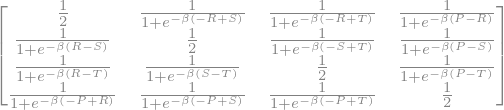

In [38]:
Rho

In [18]:
alld = [0, 0, 0]
gtft = [1, 1, q]

In [40]:
vRR = evol_dynamics.expected_distribution_last_round(gtft, gtft, delta)
vRM = evol_dynamics.expected_distribution_last_round(gtft, alld, delta)
vMR = evol_dynamics.expected_distribution_last_round(alld, gtft, delta)
vMM = evol_dynamics.expected_distribution_last_round(alld, alld, delta)

In [41]:
x = phi_last_round(vRR, vRM, vMR, vMM, N, k=1)

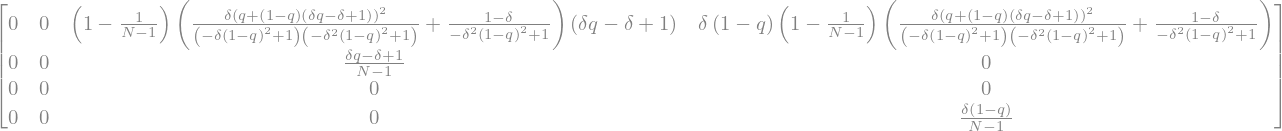

In [42]:
x

In [43]:
x[2] = x[2].factor()
x[3] = x[3].factor()

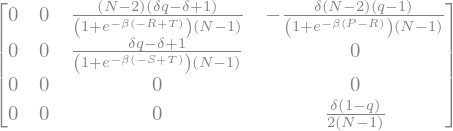

In [44]:
x.multiply_elementwise(Rho)

Thus, for the case of the last round payoffs

$$\frac{\lambda_{1}^{+}}{\lambda_{1}^{-}} = \frac{\displaystyle \frac{1}{N -1} \left(\frac{\delta \left(1 - q\right)}{2} + \frac{\delta q - \delta + 1}{\left(1 + e^{- \beta \left(- S + T\right)}\right)}\right) - \frac{N-2}{N-1} \left(\frac{\delta \left(q - 1\right)}{\left(1 + e^{- \beta \left(P - R\right)}\right)} - \frac{
\left(\delta q - \delta + 1\right)}{\left(1 + e^{- \beta \left(- R + T\right)}\right)} \right)}{\displaystyle \frac{1}{N -1} \left(\frac{\delta \left(1 - q\right)}{2} + \frac{\delta q - \delta + 1}{\left(1 + e^{- \beta \left(S - T\right)}\right)}\right) - \frac{N-2}{N-1} \left(\frac{\delta \left(q - 1\right)}{\left(1 + e^{- \beta \left(- P + R\right)}\right)} - \frac{
\left(\delta q - \delta + 1\right)}{\left(1 + e^{- \beta \left(R - T\right)}\right)} \right)}$$

In [45]:
delta = 0.999
q_val = 1 - 1 / (2 * delta)

In [46]:
evol_dynamics.expected_distribution_last_round((1, 1, q_val), 
                                                   (1, 1, q_val), delta)

In [47]:
evol_dynamics.expected_distribution_last_round((0, 0, 0), 
                                                   (1, 1, q_val), delta)

**Expected**

In [48]:
def steady_state(player, opponent, delta):
    
    v_zero = evol_dynamics.expected_distribution_opening_round(player, opponent)
    M = evol_dynamics.markov_chain_for_reactive_strategies(player, opponent)
    num = (1 - delta) * np.array(v_zero)
    inverse = sym.Matrix(np.eye(4) - delta * M).inv()

    for i, element in enumerate(inverse):
        inverse[i] = element.factor()
    
    return np.dot(num, inverse)


In [49]:
def phiExpected(vRR, vRM, vMR, vMM, N, u, beta, k=1):
    
    piMM = vMM @ u
    piMR = vMR @ u
    piRM = vRM @ u
    piRR = vRR @ u
    
    piM = (k - 1) / (N - 1) * piMM + (N - k) / (N - 1) * piMR
    piR = k / (N - 1) * piRM + (N - k - 1) / (N - 1) * piRR

    return 1 / (1 + sym.exp(-beta * (piM - piR))), 1 / (1 + sym.exp(-beta * (piR - piM)));

In [50]:
vRR = steady_state(gtft, gtft, delta)
vRM = steady_state(gtft, alld, delta)
vMR = steady_state(alld, gtft, delta)
vMM = steady_state(alld, alld, delta)

In [51]:
lambda_plus, lambda_minus = phiExpected(vRR, vRM, vMR, vMM, N, np.array([r, s, t, p]), beta, k=1)

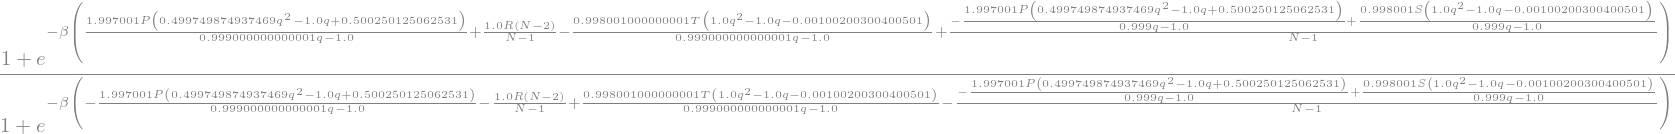

In [52]:
lambda_plus / lambda_minus

In [53]:
num = p * delta + r - t * (delta * q - delta + 1)


In [54]:
b, c = sym.symbols("b, c")

In [55]:
num.subs({r: b - c, t: b, p:0}).expand()

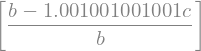

In [58]:
sym.solvers.solve(num.subs({r: b - c, t: b, p:0}).expand(), q)

In [59]:
den = - p * delta - r + t * (delta * q - delta + 1)

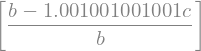

In [60]:
sym.solvers.solve(den.subs({r: b - c, t: b, p:0}).expand(), q)

In [61]:
c_val = 1
b_val = 3

1 - 1 / (3 * 0.9999)

In [62]:
gtft_val = (1, 1, 1 - 1 / (3 * 0.9999))

In [63]:
vRR = steady_state(gtft_val, gtft_val, 0.9999)
vRM = steady_state(gtft_val, alld, 0.9999)
vMR = steady_state(alld, gtft_val, 0.9999)
vMM = steady_state(alld, alld, 0.9999)

In [64]:
u = [3 - 1, -1, 3, 0]

In [65]:
k = 1

In [66]:
piMM = vMM @ u
piMR = vMR @ u
piRM = vRM @ u
piRR = vRR @ u

piM = (k - 1) / (N - 1) * piMM + (N - k) / (N - 1) * piMR
piR = k / (N - 1) * piRM + (N - k - 1) / (N - 1) * piRR


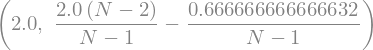

In [67]:
piM, piR

**Two opponents**

In [29]:
def calculate_rho_sixteen(u, beta):

    Us = sym.zeros(16)

    for i in range(16):
        for j in range(16):
            Us[i, j] = (u[int(j / 4)] + u[j % 4]) - (u[int(i / 4)] + u[i % 4])

    Us = Us / 2
    Rho = sym.zeros(16)

    for i in range(16):
        for j in range(16):
            Rho[i, j] = 1 / (1 + sym.exp(-beta * Us[i, j]))
    
    return Rho

In [30]:
rho = calculate_rho_sixteen([r, s, t, p], beta)

In [70]:
def phiTwoOpponents(vRR, vRM, vMR, vMM, N, k=1):
    x = sym.zeros(16)
    for i1 in range(16):
        for i2 in range(16):

            p_11 = int(i1 / 4)
            p_12 = i1 % 4
            q_21 = int(i2 / 4)
            q_22 = i2 % 4

            learner_role_model = (
                1
                / (N - 1)
                * vRM[p_11]
                * int(
                    ((p_11 == 0) and (q_21 == 0))
                    or ((p_11 == 1) and (q_21 == 2))
                    or ((p_11 == 2) and (q_21 == 1))
                    or ((p_11 == 3) and (q_21 == 3))
                )
                * (
                    1
                    / (N - 2)
                    / (N - 3)
                    * (
                        (k - 1) * (k - 2) * vRM[p_12] * vMM[q_22]
                        + (k - 1) * (N - k - 1) * vRM[p_12] * vMR[q_22]
                        + (N - k - 1) * (k - 1) * vRR[p_12] * vMM[q_22]
                        + (N - k - 1) * (N - k - 2) * vRR[p_12] * vMR[q_22]
                    )
                )
            )

            mutant_mutant = (
                (1 - 1 / (N - 1))
                / (N - 2)
                / (N - 3)
                * ((k - 1) * (k - 2) * vRM[p_11] * vMM[q_21])
                * (
                    (1 - 1 / (N - 2))
                    / (N - 3)
                    / (N - 4)
                    * (
                        (k - 2) * (k - 3) * vRM[p_12] * vMM[q_22]
                        + (k - 2) * (N - k - 1) * vRR[p_12] * vMM[q_22]
                        + (N - k - 1) * (k - 2) * vRM[p_12] * vMR[q_22]
                        + (N - k - 1) * (N - k - 2) * vRR[p_12] * vMR[q_22]
                    )
                    + 1
                    / (N - 2)
                    * vRM[p_12]
                    * int(
                    ((p_12 == 0) and (q_22 == 0))
                    or ((p_12 == 1) and (q_22 == 2))
                    or ((p_12 == 2) and (q_22 == 1))
                    or ((p_12 == 3) and (q_22 == 3))
                )
                )
            )

            mutant_resident = (
                (1 - 1 / (N - 1))
                / (N - 2)
                / (N - 3)
                * ((k - 1) * (N - k - 1) * vRM[p_11] * vMR[q_21])
                * (
                    (1 - 1 / (N - 2))
                    / (N - 3)
                    / (N - 4)
                    * (
                        (k - 1) * (k - 3) * vRM[p_12] * vMM[q_22]
                        + (k - 1) * (N - k - 1) * vRR[p_12] * vMM[q_22]
                        + (N - k - 2) * (k - 2) * vRM[p_12] * vMR[q_22]
                        + (N - k - 2) * (N - k - 2) * vRR[p_12] * vMR[q_22]
                    )
                    + 1
                    / (N - 2)
                    * vRM[p_12]
                    * int(
                    ((p_12 == 0) and (q_22 == 0))
                    or ((p_12 == 1) and (q_22 == 2))
                    or ((p_12 == 2) and (q_22 == 1))
                    or ((p_12 == 3) and (q_22 == 3))
                )
                )
            )

            resident_mutant = (
                (1 - 1 / (N - 1))
                / (N - 2)
                / (N - 3)
                * ((N - k - 1) * (k - 1) * vRR[p_11] * vMM[q_21])
                * (
                    (1 - 1 / (N - 2))
                    / (N - 3)
                    / (N - 4)
                    * (
                        (k - 2) * (k - 2) * vRM[p_12] * vMM[q_22]
                        + (k - 2) * (N - k - 2) * vRR[p_12] * vMM[q_22]
                        + (N - k - 1) * (k - 1) * vRM[p_12] * vMR[q_22]
                        + (N - k - 1) * (N - k - 3) * vRR[p_12] * vMR[q_22]
                    )
                    + 1
                    / (N - 2)
                    * vRM[p_12]
                    * int(
                    ((p_12 == 0) and (q_22 == 0))
                    or ((p_12 == 1) and (q_22 == 2))
                    or ((p_12 == 2) and (q_22 == 1))
                    or ((p_12 == 3) and (q_22 == 3))
                )
                )
            )

            resident_resident = (
                (1 - 1 / (N - 1))
                / (N - 2)
                / (N - 3)
                * (N - k - 1)
                * (N - k - 2)
                * vRR[p_11]
                * vMR[q_21]
                * (
                    (1 - 1 / (N - 2))
                    / (N - 3)
                    / (N - 4)
                    * (
                        (k - 1) * (k - 2) * vRM[p_12] * vMM[q_22]
                        + (k - 1) * (N - k - 2) * vRR[p_12] * vMM[q_22]
                        + (N - k - 2) * (k - 1) * vRM[p_12] * vMR[q_22]
                        + (N - k - 2) * (N - k - 3) * vRR[p_12] * vMR[q_22]
                    )
                    + 1
                    / (N - 2)
                    * vRM[p_12]
                    * int(
                    ((p_12 == 0) and (q_22 == 0))
                    or ((p_12 == 1) and (q_22 == 2))
                    or ((p_12 == 2) and (q_22 == 1))
                    or ((p_12 == 3) and (q_22 == 3))
                )
                )
            )

            x[i1, i2] = learner_role_model + (
                mutant_mutant + mutant_resident + resident_mutant + resident_resident
            )
    return x

In [15]:
delta = sym.symbols("\delta")

In [83]:
vRR = evol_dynamics.expected_distribution_last_round(gtft, gtft, delta)
vRM = evol_dynamics.expected_distribution_last_round(gtft, alld, delta)
vMR = evol_dynamics.expected_distribution_last_round(alld, gtft, delta)
vMM = evol_dynamics.expected_distribution_last_round(alld, alld, delta)

In [86]:
x = phiTwoOpponents(vRR, vRM, vMR, vMM, N, k=1)

In [87]:
import itertools

In [45]:
list(itertools.product(["R", "S", "T", "P"], repeat=4))[63]

('R', 'P', 'P', 'P')

In [89]:
for i, element in enumerate(x):
    x[i] = element.factor()

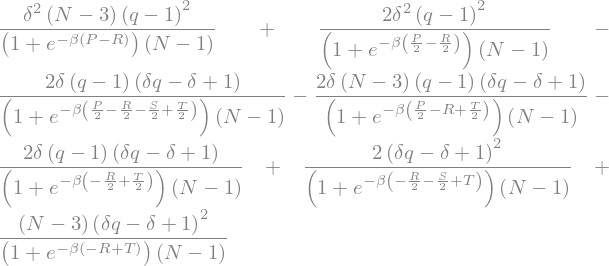

In [90]:
sum(x.multiply_elementwise(rho))

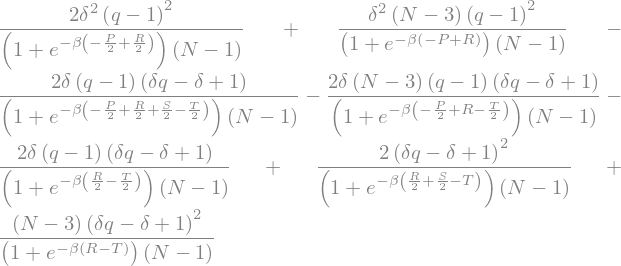

In [91]:
sum(x.multiply_elementwise(rho.T))

Thus, for the case of the two last opponents

$\frac{\lambda_{1}^{+}}{\lambda_{1}^{-}} = \frac{\displaystyle \frac{1}{N -1} \left(\frac{2 \delta^{2} \left(q - 1\right)^{2}}{\left(1 + e^{- \beta \left(\frac{P}{2} - \frac{R}{2}\right)}\right)} - \frac{2 \delta \left(q - 1\right) \left(\delta q - \delta + 1\right)}{\left(1 + e^{- \beta \left(\frac{P}{2} - \frac{R}{2} - \frac{S}{2} + \frac{T}{2}\right)}\right)}  - \frac{2 \delta \left(q - 1\right) \left(\delta q - \delta + 1\right)}{\left(1 + e^{- \beta \left(- \frac{R}{2} + \frac{T}{2}\right)}\right)} + \frac{2 \left(\delta q - \delta + 1\right)^{2}}{\left(1 + e^{- \beta \left(- \frac{R}{2} - \frac{S}{2} + T\right)}\right)}  \right) + \frac{N-3}{N-1} \left( \displaystyle \frac{\delta^{2} \left(q - 1\right)^{2}}{\left(1 + e^{- \beta \left(P - R\right)} \right)} - \frac{2 \delta \left(q - 1\right) \left(\delta q - \delta + 1\right)}{\left(1 + e^{- \beta \left(\frac{P}{2} - R + \frac{T}{2}\right)}\right)} + \frac{ \left(\delta q - \delta + 1\right)^{2}}{\left(1 + e^{- \beta \left(- R + T\right)}\right)} \right)}
{\displaystyle \frac{1}{N -1} \left(\frac{2 \delta^{2} \left(q - 1\right)^{2}}{\left(1 + e^{- \beta \left(-\frac{P}{2} + \frac{R}{2}\right)}\right)} - \frac{2 \delta \left(q - 1\right) \left(\delta q - \delta + 1\right)}{\left(1 + e^{- \beta \left(-\frac{P}{2} + \frac{R}{2} + \frac{S}{2} - \frac{T}{2}\right)}\right)}  - \frac{2 \delta \left(q - 1\right) \left(\delta q - \delta + 1\right)}{\left(1 + e^{- \beta \left(\frac{R}{2} - \frac{T}{2}\right)}\right)} + \frac{2 \left(\delta q - \delta + 1\right)^{2}}{\left(1 + e^{- \beta \left(\frac{R}{2} + \frac{S}{2} - T\right)}\right)}  \right) + \frac{N-3}{N-1} \left( \displaystyle \frac{\delta^{2} \left(q - 1\right)^{2}}{\left(1 + e^{- \beta \left(- P + R\right)} \right)} - \frac{2 \delta \left(q - 1\right) \left(\delta q - \delta + 1\right)}{\left(1 + e^{- \beta \left(-\frac{P}{2} + R + \frac{T}{2}\right)}\right)} + \frac{ \left(\delta q - \delta + 1\right)^{2}}{\left(1 + e^{- \beta \left(R - T\right)}\right)} \right)}$

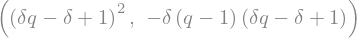

In [92]:
sym.fraction(x[26])[0], sym.fraction(x[11])[0] / (N - 3)

In [93]:
num = ((sym.fraction(x[26])[0]) + 2 *  sym.fraction(x[11])[0] / (N - 3)).factor()

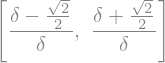

In [94]:
sym.solvers.solve((num - delta ** 2 * (q - 1) ** 2).factor(), q)

In [95]:
den = (delta ** 2 * (q - 1) ** 2) + 2 *  sym.fraction(x[11])[0] / (N - 3)
den.factor()

In [96]:
(delta ** 2 * (q - 1) ** 2)

In [97]:
2 *  sym.fraction(x[11])[0] / (N - 3)

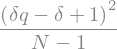

In [98]:
x[26]

In [99]:
sym.fraction(x[26])[0]

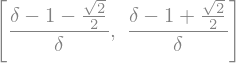

In [100]:
sym.solvers.solve((sym.fraction(x[26])[0]  - den).factor(), q)

In [101]:
import math

In [102]:
math.sqrt(2) / 2

In [103]:
1 - 1 / 3

**Two rounds**

In [16]:
def stationary(s_1, s_2, delta):
    
    v_zero = sym.Matrix(evol_dynamics.expected_distribution_opening_round(s_1, s_2))
    M = evol_dynamics.markov_chain_for_reactive_strategies(s_1, s_2)
    
    rhs = v_zero.T * sym.Matrix((np.eye(4) - delta * M)).inv() 
    
    v = sym.zeros(4)
    
    
    for i in range(4):
        for j in range(4):
    
            v[i, j] = (1 - delta) * M[i, j] * (delta ** 2) * rhs[i]
        
    return v.reshape(1, 16)

In [19]:
vRR = stationary(gtft, gtft, delta)
vRM = stationary(gtft, alld, delta)
vMR = stationary(alld, gtft, delta)
vMM = stationary(alld, alld, delta)

In [20]:
def phiTwoRounds(vRR, vRM, vMR, vMM, N, k=1):

    x = sym.zeros(16)
    for i in range(16):
        for j in range(16):

            x[i, j] = 1 / (N - 1) * vRM[i] * int(
                ((i == 0) and (j == 0))
                or ((i == 1) and  (j == 2))
                or ((i == 2) and  (j == 1))
                or ((i == 3) and  (j == 3))
                or ((i == 4) and  (j == 8))
                or ((i == 5) and  (j == 10))
                or ((i == 6) and  (j == 9))
                or ((i == 7) and  (j == 11))
                or ((i == 8) and  (j == 4))
                or ((i == 9)  and (j == 6))
                or ((i == 10) and (j == 5))
                or ((i == 11) and (j == 7))
                or ((i == 12) and (j == 12))
                or ((i == 13) and (j == 14))
                or ((i == 14) and (j == 13))
                or ((i == 15) and (j == 15))
            ) + (1 - 1 / (N - 1)) / (N - 2) / (N - 3) * (
                (k - 1) * (k - 2) * vRM[i] * vMM[j]
                + (k - 1) * (N - k - 1) * vRM[i] * vMR[j]
                + (N - k - 1) * (k - 1) * vRR[i] * vMM[j]
                + (N - k - 1) * (N - k - 2) * vRR[i] * vMR[j]
            )

    return x

In [25]:
x = phiTwoRounds(vRR, vRM, vMR, vMM, N, k=1)

In [26]:
for i, element in enumerate(x):
    x[i] = element.factor()

In [92]:
b, c = sym.symbols("b, c")

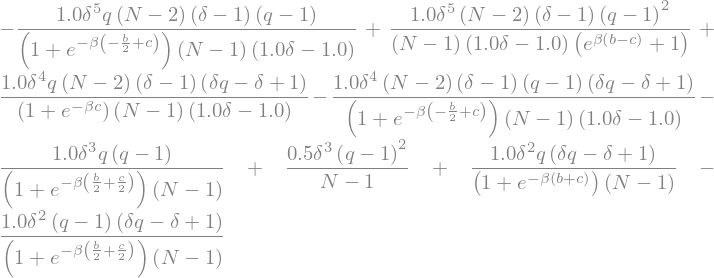

In [96]:
sum(x.multiply_elementwise(rho)).subs({r: b -c, p: 0, t: b, s: -c})

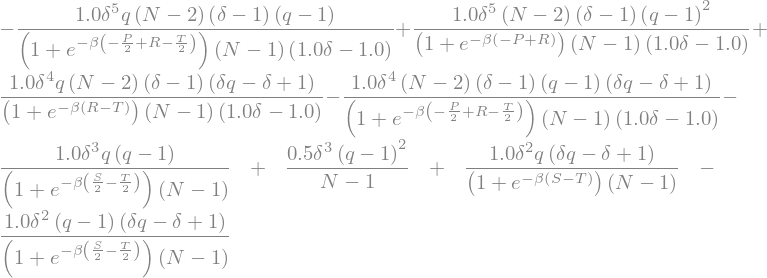

In [32]:
sum(x.multiply_elementwise(rho.T))

In [97]:
expr = (x[14] / (N - 2) * (N - 1)).factor() + (x[11] / (N - 2) * (N - 1)).factor()

In [99]:
expr

In [48]:
num = sym.fraction(x[10].simplify() / (N - 2) * (N - 1))[0]
num

In [58]:
den = sym.fraction((x[15] / (N - 2) * (N - 1)) / (delta - 1) * (1.0 * delta - 1.0))[0]

In [59]:
den


In [60]:
(num + expr - den).simplify()

In [55]:
num + expr

In [86]:
sol = sym.solvers.solve((num + expr - den).factor(), q)

In [87]:
len(sol)

In [91]:
sol[0].subs({delta: 1})

In [66]:
(num + expr - den).subs({delta: 1}).factor()

In [67]:
sol = sym.solvers.solve(num - expr - den, q)

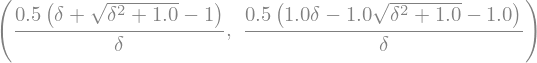

In [68]:
sol[1].simplify(), sol[0].factor()

In [69]:
len(sol)

In [70]:
exp = (num - expr - den).subs({delta: 1})

In [77]:
q_val = np.linspace(0, 1, 100)

In [78]:
q_val

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [79]:
points = [exp.subs({q: i}) for i in q_val]

In [80]:
import matplotlib.pyplot as plt

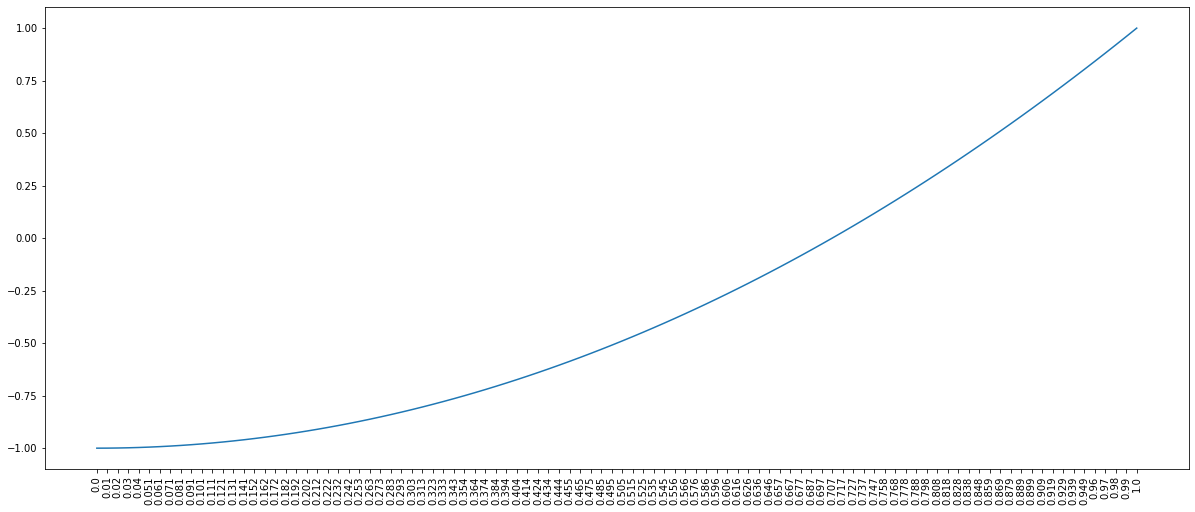

In [81]:
fig, axes = plt.subplots(figsize=(20.5, 8.5))

axes.plot(points);

axes.set_xticks(range(100));

axes.set_xticklabels(q_val.round(3), rotation=90);

